# Simple Pendulum 3D simulation

We are going to solve the simple pendulum in 3D.

Before we start, let's import some libraries:

* `numpy` for numerical calculations
* `matplotlib` for plotting
* `matplotlib.animation` for animating the pendulum
* `mpl_toolkits.mplot3d` for 3D plotting
* `IPython.display` for displaying the animation
* `scipy.integrate` for solving the differential equation
* `sympy` for symbolic calculations

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from scipy.integrate import odeint
import sympy as sym

Let's define somethings first:

* $m$ is the mass of the pendulum bob
* $l$ is the length of the pendulum
* $g$ is the acceleration due to gravity
* $t$ is the time
* $\theta$ is the azimuthal angle as function of $t$ (the angle between in $xy$ plane, it goes from $0$ to $2\pi$)
* $\phi$ is the polar angle as function of $t$ (the angle between the $z$-axis and the pendulum rod it goes from $0$ to $\pi$)

In [184]:
# Constants
m = sym.symbols('m', real=True, positive=True, constant=True)
l = sym.symbols('l', real=True, positive=True, constant=True)
g = sym.symbols('g', real=True, positive=True, constant=True)
t = sym.symbols('t', real=True, positive=True, variable=True)

# Functions of time
theta = sym.Function('\\theta')(t)
phi = sym.Function('\\phi')(t)

Now, we need to define the kinetic energy and potential energy of the pendulum:

$$ T = \frac{1}{2} m \dot{x}^2 + \frac{1}{2} m \dot{y}^2 + \frac{1}{2} m \dot{z}^2 $$

$$ V = m g z$$

here $x$, $y$ and $z$ are the coordinates of the pendulum bob and $\dot{x}$, $\dot{y}$ and $\dot{z}$ are the velocities of the pendulum bob.

So we need to define $x$, $y$ and $z$ as functions of $\theta$ and $\phi$:

$$ x = l \sin \theta \cos \phi $$
$$ y = l \sin \theta \sin \phi $$
$$ z = l \cos \theta $$

so let's define $x$, $y$ and $z$ as functions of $\theta$ and $\phi$:

In [185]:
# Spherical coordinates to Cartesian coordinates
x = l * sym.sin(theta) * sym.cos(phi)
y = l * sym.sin(theta) * sym.sin(phi)
z = l * sym.cos(theta)

We can now define the kinetic energy and potential energy:

In [186]:
# Kinetic energy
T = (1/2) * m * (x.diff(t)**2 + y.diff(t)**2 + z.diff(t)**2)

# Potential energy
V = m * g * z

We can check kinetic energy:

In [187]:
T

0.5*m*(l**2*sin(\theta(t))**2*Derivative(\theta(t), t)**2 + (-l*sin(\phi(t))*sin(\theta(t))*Derivative(\phi(t), t) + l*cos(\phi(t))*cos(\theta(t))*Derivative(\theta(t), t))**2 + (l*sin(\phi(t))*cos(\theta(t))*Derivative(\theta(t), t) + l*sin(\theta(t))*cos(\phi(t))*Derivative(\phi(t), t))**2)

And potential energy:

In [188]:
V

g*l*m*cos(\theta(t))

With the kinetic energy and potential energy, we can define the Lagrangian:

$$ L = T - V $$

In [189]:
L = T - V

In [190]:
L

-g*l*m*cos(\theta(t)) + 0.5*m*(l**2*sin(\theta(t))**2*Derivative(\theta(t), t)**2 + (-l*sin(\phi(t))*sin(\theta(t))*Derivative(\phi(t), t) + l*cos(\phi(t))*cos(\theta(t))*Derivative(\theta(t), t))**2 + (l*sin(\phi(t))*cos(\theta(t))*Derivative(\theta(t), t) + l*sin(\theta(t))*cos(\phi(t))*Derivative(\phi(t), t))**2)

Now that we have the Lagrangian, we can define the Euler-Lagrange equation, in order to find the equations of motion, as we have 2 degrees of freedom, we need to find 2 equations of motion:

$$ \frac{d}{dt} \frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = 0 $$

$$ \frac{d}{dt} \frac{\partial L}{\partial \dot{\phi}} - \frac{\partial L}{\partial \phi} = 0 $$

In [191]:
LE_theta = (L.diff(theta.diff(t)).diff(t) - L.diff(theta)).simplify()
LE_phi = (L.diff(phi.diff(t)).diff(t) - L.diff(phi)).simplify()

Euler-Lagrange equation for $\theta$:

In [192]:
LE_theta

1.0*l*m*(-g*sin(\theta(t)) - l*sin(2*\theta(t))*Derivative(\phi(t), t)**2/2 + l*Derivative(\theta(t), (t, 2)))

Euler-Lagrange equation for $\phi$:

In [193]:
LE_phi

l**2*m*(sin(2*\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) - cos(2*\theta(t))*Derivative(\phi(t), (t, 2))/2 + Derivative(\phi(t), (t, 2))/2)

Now let's solve each equation for $\ddot{\theta}$ and $\ddot{\phi}$:

In [194]:
sols = sym.solve([LE_theta, LE_phi], [theta.diff(t).diff(t), phi.diff(t).diff(t)], rational=True, simplify=True)

Equation for $\ddot{\theta}$:

In [195]:
sols[theta.diff(t, 2)]

(g + l*cos(\theta(t))*Derivative(\phi(t), t)**2)*sin(\theta(t))/l

Equation for $\ddot{\phi}$:

In [196]:
sols[phi.diff(t, 2)]

-2*Derivative(\phi(t), t)*Derivative(\theta(t), t)/tan(\theta(t))

Now we have 2 coupled diffential second order equations, so we need to make them first order differential equations, so we can solve them numerically.

First we introduce the new variables:

$$ \dot{\theta} = \omega $$
$$ \dot{\phi} = \nu $$

We can rewrite the equations of motion:

$$
\begin{align*}
\dot{\omega} &= ... \\
\dot{\nu} &= ... \\
\dot{\theta} &= \omega \\
\dot{\phi} &= \nu
\end{align*}
$$

Now we can define the function that will be passed to the numerical solver:

In [197]:
omega_f = sym.lambdify((m, l, g, t, theta, phi, theta.diff(t),  phi.diff(t)), sols[theta.diff(t, 2)])
nu_f = sym.lambdify((m, l, g, t, theta, phi, theta.diff(t),  phi.diff(t)), sols[phi.diff(t, 2)])
theta_f = sym.lambdify(theta.diff(t), theta.diff(t))
phi_f = sym.lambdify(phi.diff(t), phi.diff(t))

We can define a function `dSdt` that receives the state vector `S`, `t`, `m`, `l` and `g` and returns the derivatives of the state vector, we only do this to make the code more readable.

In [198]:
def dSdt(S, t, m, l, g):
    theta, omega, phi, nu = S
    return [
        theta_f(omega),
        omega_f(m, l, g, t, theta, phi, omega ,nu),
        phi_f(nu),
        nu_f(m, l, g, t, theta, phi, omega ,nu),
    ]

At this point, we can solve the equations of motion numerically, we will use `scipy.integrate.odeint` to solve the equations of motion. We will use the initial conditions $\theta = \pi/2$, $\phi = \pi/4$, $\omega = 0$ and $\nu = 0$, and we solve for $t \in [0, 10]$.

In [199]:
tf = 40
t = np.linspace(0, tf, 25*tf)
S0 = [np.deg2rad(45), 0, np.deg2rad(12), 2]
S = odeint(dSdt, S0, t, args=(1, 1, 9.81))

Now we can plot the results:

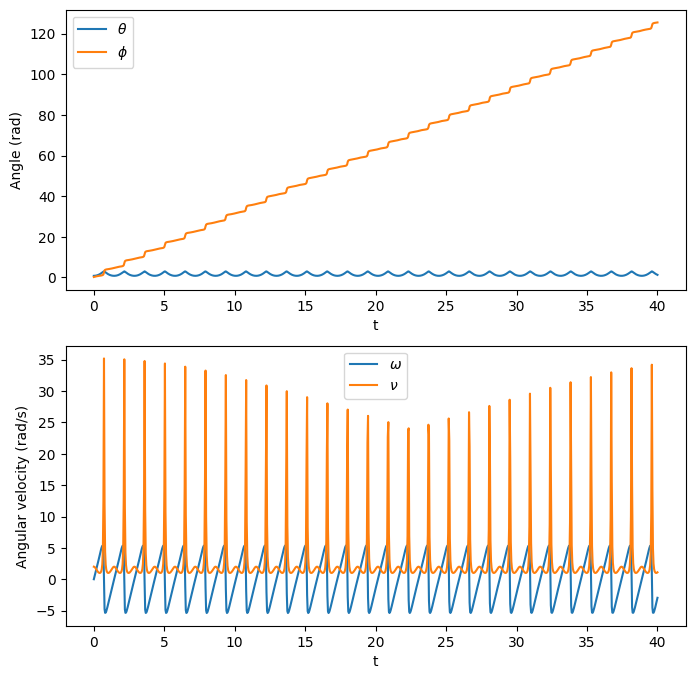

In [200]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(t, S[:, 0], label='$\\theta$')
ax[0].plot(t, S[:, 2], label='$\\phi$')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Angle (rad)')
ax[0].legend()
ax[1].plot(t, S[:, 1], label='$\\omega$')
ax[1].plot(t, S[:, 3], label='$\\nu$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('Angular velocity (rad/s)')
ax[1].legend()
plt.show()

Now we can animate the results:

In [201]:
def x_y_z(theta, phi, l):
    x = l * np.sin(theta) * np.cos(phi)
    y = l * np.sin(theta) * np.sin(phi)
    z = l * np.cos(theta)
    return x, y, z

MovieWriter ffmpeg unavailable; using Pillow instead.


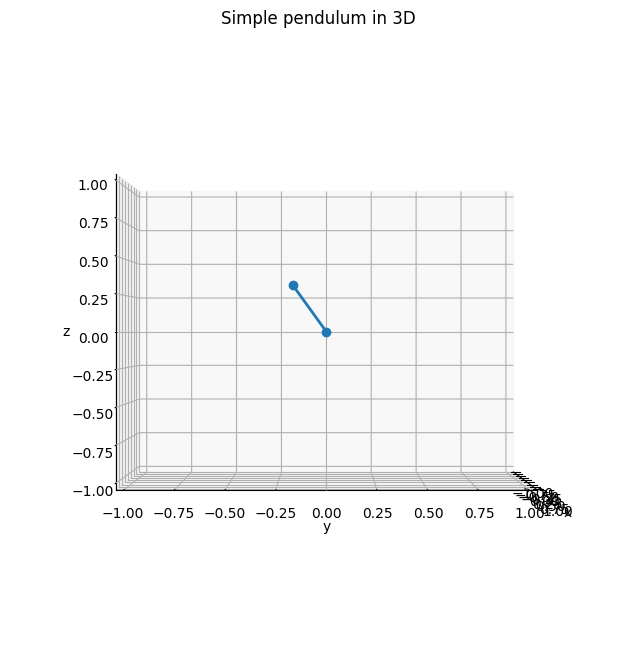

In [213]:
# Cartesian coordinates
x, y, z = x_y_z(S[:, 0], S[:, 2], 1)

# Create an animation
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Simple pendulum in 3D')
ax.view_init(0, 0)
line, = ax.plot([], [], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

def animate(i):
    thisx = [0, x[i]]
    thisy = [0, y[i]]
    thisz = [0, z[i]]
    line.set_data(thisx, thisy)
    line.set_3d_properties(thisz)
    # Rotate the view angle by 1 degree
    # ax.view_init(elev=10., azim=i)
    return line,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=20, blit=True)
ani.save('simple_pendulum_3d.gif', fps=len(t[t<1]))

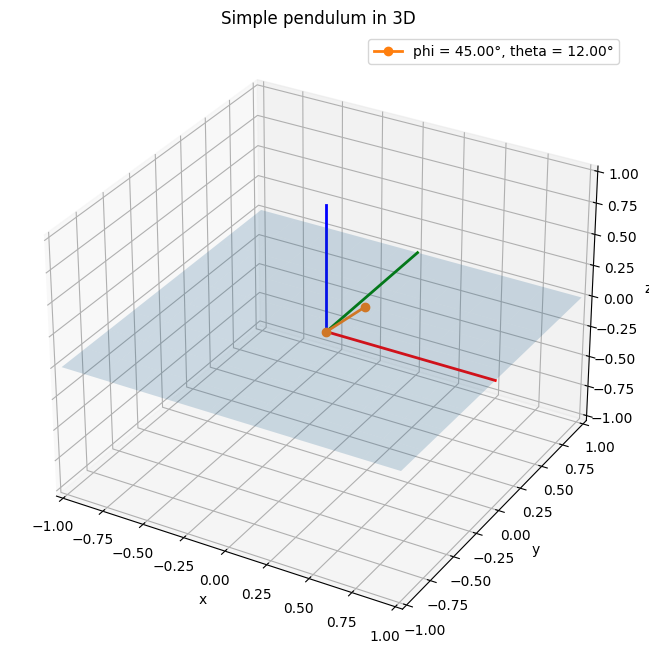

In [212]:
# Plot initial position
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Simple pendulum in 3D')
# Plot z=0 plane
xx, yy = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.2)
# Plot x, y, z axes
ax.plot([0, 1], [0, 0], [0, 0], 'r', lw=2)
ax.plot([0, 0], [0, 1], [0, 0], 'g', lw=2)
ax.plot([0, 0], [0, 0], [0, 1], 'b', lw=2)

# Show angle between pendulum and z=0 plane
angle = np.arccos(z[0])

# Show angle between x axis and pendulum
angle2 = np.arccos(x[0] / np.sqrt(x[0]**2 + y[0]**2))

# Set view from above
# ax.view_init(0, 0)


# Plot initial position
ax.plot([0, x[121]], [0, y[121]], [0, z[121]], 'o-', lw=2, label = f'phi = {np.rad2deg(angle):.2f}°, theta = {np.rad2deg(angle2):.2f}°')
ax.legend()
plt.show()